# 2019 Capital Bikeshare Data Exploration
##  by Mohamed Mounir Awadallah

## Investigation Overview

**Capital Bikeshare** is metro DC's bikeshare service, with 4,500 bikes and 500+ stations across 7 jurisdictions. Designed for quick trips with convenience in mind, it’s a fun and affordable way to get around.

## Dataset Overview

The dataset used for this exploratory analysis consists of monthly individual trip data from January 2019 to December 2019 in CSV format, also available [here](https://s3.amazonaws.com/capitalbikeshare-data/index.html).

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from glob import glob

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load in the dataset into a pandas dataframe
data_files = sorted(glob('./data/*-capitalbikeshare-tripdata.csv'))
cabital = pd.concat((pd.read_csv(file).assign(filename = file)
                    for file in data_files), ignore_index = True)

In [3]:
# changing the duration unit to minutes
cabital['Duration'] = (cabital['Duration'] / 60).round(2)

# converting start date and end date data types into datetime
cabital['Start date'] = pd.to_datetime(cabital['Start date'])
cabital['End date'] = pd.to_datetime(cabital['End date'])

# extracting Day, Week and Month from Start date
cabital['Day'] = cabital['Start date'].dt.day_name()
cabital['Month'] = cabital['Start date'].dt.month_name()

In [4]:
# extracting Day type from day
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekend = ['Saturday', 'Sunday']

weekdays_index = cabital.loc[cabital['Day'].isin(weekdays)].index
weekend_index = cabital.loc[cabital['Day'].isin(weekend)].index

cabital['Day type'] = ''
cabital['Day type'][weekdays_index] = 'Weekday'
cabital['Day type'][weekend_index] = 'Weekend'

In [5]:
# extracting Season fron Start date
spring = ['March', 'April', 'May']
summer = ['June', 'July', 'August']
fall = ['September', 'October', 'November']
winter = ['December', 'January', 'February']

spring_index = cabital.loc[cabital['Month'].isin(spring)].index
summer_index = cabital.loc[cabital['Month'].isin(summer)].index
fall_index = cabital.loc[cabital['Month'].isin(fall)].index
winter_index = cabital.loc[cabital['Month'].isin(winter)].index

cabital['Season'] = ''
cabital['Season'][spring_index] = 'Spring'
cabital['Season'][summer_index] = 'Summer'
cabital['Season'][fall_index] = 'Fall'
cabital['Season'][winter_index] = 'Winter'

In [6]:
# setting color palettes
base_color = sb.color_palette()[0]
day_type_color = [sb.color_palette()[2],sb.color_palette()[3]]

# setting seasons order
seasons = ['Spring','Summer','Fall','Winter']

## Member Types

We can see that the number of trips made by members is greater than the trips made by casual members.

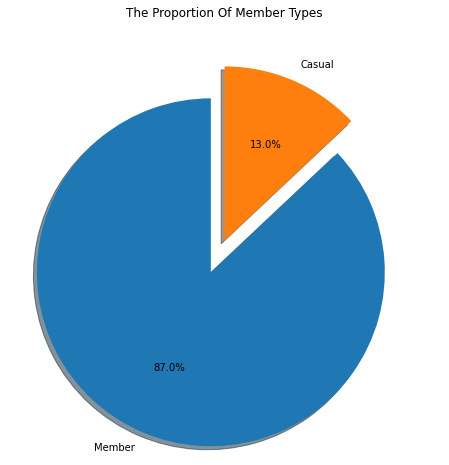

In [7]:
# the proportion of member types
Member = cabital['Member type'].value_counts()
explode = [0.2, 0]
plt.figure(figsize=[8, 8])
plt.pie(Member, labels=Member.index,startangle=90,explode = explode,
        shadow = True, autopct='%1.1f%%');
plt.title('The Proportion Of Member Types');

## Average Daily Trips

The average daily trips are affected by Day type, Season.

- Average daily trips increases in the Summer months, while it decreases in the Winter months.
- Average daily trips on weekends are lower than daily trips on weekdays.

In [8]:
# calculating the average daily trips per season
season_counts = cabital.groupby(['Season']).count()['Duration']
season_daily = pd.DataFrame(season_counts / 91).reset_index()
season_daily.rename(columns = {'Duration':'Daily trips'}, inplace = True)

# setting start and end date
start_date =  cabital['Start date'].min().date()
end_date =  cabital['Start date'].max().date()

# calculating the number of weekdays and weekends in the whole period of time
no_of_weekdays = np.busday_count(start_date,end_date,'1111100')
no_of_weekends = np.busday_count(start_date,end_date,'0000011')

# calculating the average number of trips on both day types
week_counts = cabital.groupby(['Day type']).count()['Duration']
week_proportion = pd.DataFrame(week_counts / [no_of_weekdays ,no_of_weekends]).reset_index()
week_proportion.rename(columns = {'Duration':'Daily trips'}, inplace = True)

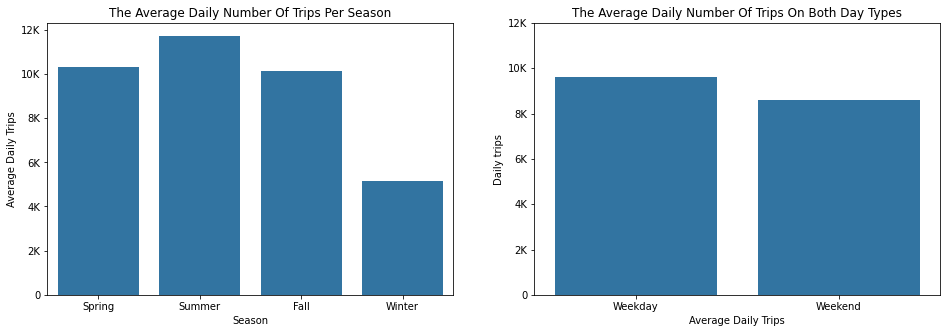

In [9]:
fig, ax = plt.subplots(ncols=2, figsize = [16,5])

# the average daily trips per season
sb.barplot(data=season_daily, x='Season', y='Daily trips', order=seasons, color=base_color, ax=ax[0])
ax[0].title.set_text('The Average Daily Number Of Trips Per Season')
ax[0].set_xlabel('Season')
ax[0].set_ylabel('Average Daily Trips')
ax[0].set_yticks([0,2000,4000,6000,8000,10000,12000])
ax[0].set_yticklabels(['0','2K','4K','6K','8K','10K','12K']);

# the average daily trips on both day types
sb.barplot(data=week_proportion, x='Day type', y='Daily trips', color=base_color, ax=ax[1])
ax[1].title.set_text('The Average Daily Number Of Trips On Both Day Types')
ax[1].set_xlabel('Day Type')
ax[1].set_xlabel('Average Daily Trips')
ax[1].set_yticks([0,2000,4000,6000,8000,10000,12000])
ax[1].set_yticklabels(['0','2K','4K','6K','8K','10K','12K']);

##  Distribution of Trip Durations

Trip durations in the dataset take on a large range of values, from 1 minute at the lowest, to about 250 minutes at the highest. Plotted on a logarithmic scale, the distribution of trip durations takes on a bell-shaped curve.

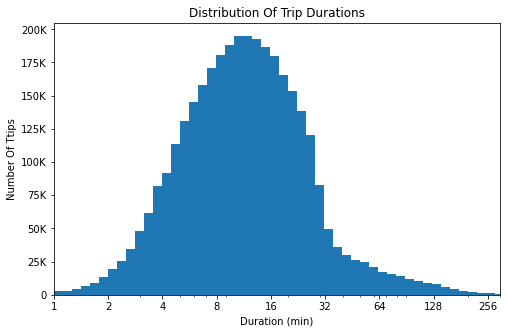

In [10]:
# distribution of trip durations
log_binsize = 0.05
bins = 10 ** np.arange(0, np.log10(cabital['Duration'].max())+log_binsize, log_binsize)
x_ticks = [1,2,4,8,16,32,64,128,256]
plt.figure(figsize=[8, 5])
plt.hist(data = cabital,x='Duration' ,bins = bins)
plt.xlim([1,300])
plt.xscale('log')
plt.xticks(x_ticks,x_ticks)
plt.yticks([0,25000,50000,75000,100000,125000,150000,175000,200000],
          ['0','25K','50K','75K','100K','125K','150K','175K','200K'])
plt.title('Distribution Of Trip Durations')
plt.xlabel('Duration (min)')
plt.ylabel('Number Of Ttips');

## Duration by Day type, Season, and Member type

The duration of the trip is affected by Day type, Season, and Member type.
- Trips in Spring and Summer are longer than trips in Fall and Winter.
- Trips on Weekends are longer than trips on Weekdays.
- Trips by Casual Members are longer than trips by Members.


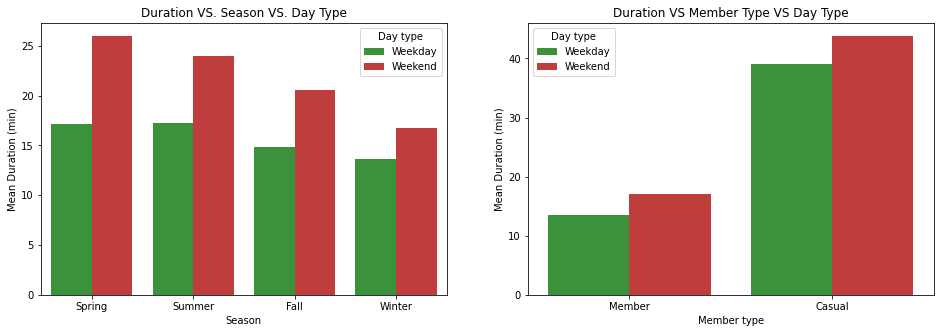

In [11]:
fig, ax = plt.subplots(ncols=2, figsize = [16,5])

sb.barplot(data=cabital, x='Season', y='Duration', hue='Day type', ci=None,
           palette=day_type_color, order=seasons, ax = ax[0])
ax[0].title.set_text('Duration VS. Season VS. Day Type')
ax[0].set_ylabel('Mean Duration (min)');

sb.barplot(data=cabital, x='Member type', y='Duration', hue='Day type', ci=None,
           palette=day_type_color, ax = ax[1])
ax[1].title.set_text('Duration VS Member Type VS Day Type')
ax[1].set_ylabel('Mean Duration (min)');